# Recommendations Systems
## Homework 2: Content Based Recommendations 
**By Millis Sahar** (approved by Asi)

<br>

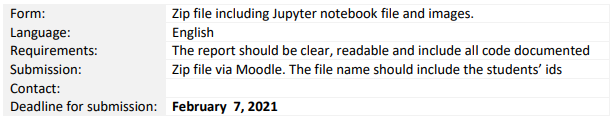

<br>

Students will form teams of two people each, and submit a single homework for each team.   
The same score for the homework will be given to each member of the team. 

Submit your solution in the form of an Jupyter notebook file (with extension ipynb).   
Images of graphs or tables should be submitted as PNG or JPG files.   
The code used to answer the questions should be included, runnable and documented in the notebook.   
Python 3.6 should be used.

The goal of this homework is to let you understand the concept of  recommendations based on implicit data which is very common in real life, and learn how ‘Deep neural networks’ components can be used to implement a collaborative filtering and hybrid approach recommenders.  
Implementation example is presented in the <a href='https://colab.research.google.com/drive/1v72_zpCObTFMbNnQXUknoQVXR1vBRX6_?usp=sharing'>NeuralCollaborativeFiltering_Implicit</a> notebook in Moodle  (and here is  <a href='https://colab.research.google.com/drive/19MHT7ewRv8TfX7eheGeLCys5mRa7neCK?usp=sharing'>Neural Collaborative Filtering Explicit</a>).

**Submission:**   
Submission of the homework will be done via Moodle by uploading a zip file containing a Jupyter notbook and images.  
The homework needs to be entirely in English.   
The deadline for submission of Homework 3 is set to February 7, 2021 end of day Israel.


We will use a dataset based on the <a href='https://grouplens.org/datasets/movielens/1m/'>MovieLens 1M rating dataset</a> after some pre-processing to adapt it to an implicit feedback use case scenario.  
You can download the dataset used by <a href='https://github.com/hexiangnan/neural_collaborative_filtering'>this implementation</a> of the paper Neural Collaborative Filtering or from the <a href='https://colab.research.google.com/drive/1v72_zpCObTFMbNnQXUknoQVXR1vBRX6_?usp=sharing#scrollTo=AV1al-v0zWt1'>NeuralCollaborativeFiltering_implicit</a> notebook in Moodle.

<br>
Note:
Article review: <a href='https://towardsdatascience.com/paper-review-neural-collaborative-filtering-explanation-implementation-ea3e031b7f96'>https://towardsdatascience.com/paper-review-neural-collaborative-filtering-explanation-implementation-ea3e031b7f96</a>


<br><br><br>
<br><br><br>
<br><br><br>

**Imports**

In [467]:
import time
import os 

# general
import warnings
import numpy as np
import scipy as sp
import pandas as pd

# visual
import seaborn as sns
import wordcloud as wc
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

# visual 3D
from mpl_toolkits import mplot3d

# logic
import torch
from torch import nn
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Embedding,Linear,Dropout

from torch.optim import SGD,Adam
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose


# notebook
from IPython.display import display, HTML

**Hide Warnings**

In [2]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

**Set Device**

In [432]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

<br><br><br>
<br><br><br>
<br><br><br>

## Question 1: Dataset preparation (10 points)
<br><br>

This implementation contains one file for training and two files for testing:   
- ml-1m.train.rating   
- ml-1m.test.rating  
- ml-1m.test.negative   

<br>

a. **Explain** the role and structure of each file and how it was created from the original MovieLens 1M rating dataset.

From the READMEFILE:     

        RATINGS FILE DESCRIPTION
        
        All ratings are contained in the file "ratings.dat" and are in the
        following format:

        UserID::MovieID::Rating::Timestamp

        - UserIDs range between 1 and 6040 
        - MovieIDs range between 1 and 3952
        - Ratings are made on a 5-star scale (whole-star ratings only)
        - Timestamp is represented in seconds since the epoch as returned by time(2)
        - Each user has at least 20 ratings

We take the original file `rating.dat` and devide it into train & test.  
- The train file `ml-1m.train.rating.txt` will include all the ratings besides the last rating of each user (sorted by the timestamp).  
- The test file `ml-1m.test.rating.txt` will inlude all just the last rating of each user.  

<br>

Finally, the file `ml-1m.test.negative.txt`, is different.  
Each line in the file contains a tubple (userId,itemId) that corresponds to the line of test.rating.  
And the rest of the row is a 99 negative samples - meaning 99 movies that the user isn't interact at all in `rating.dat`.  

<br><br><br>

b. **Explain** how the training dataset is created.

Explain it in words above, but here is an image:
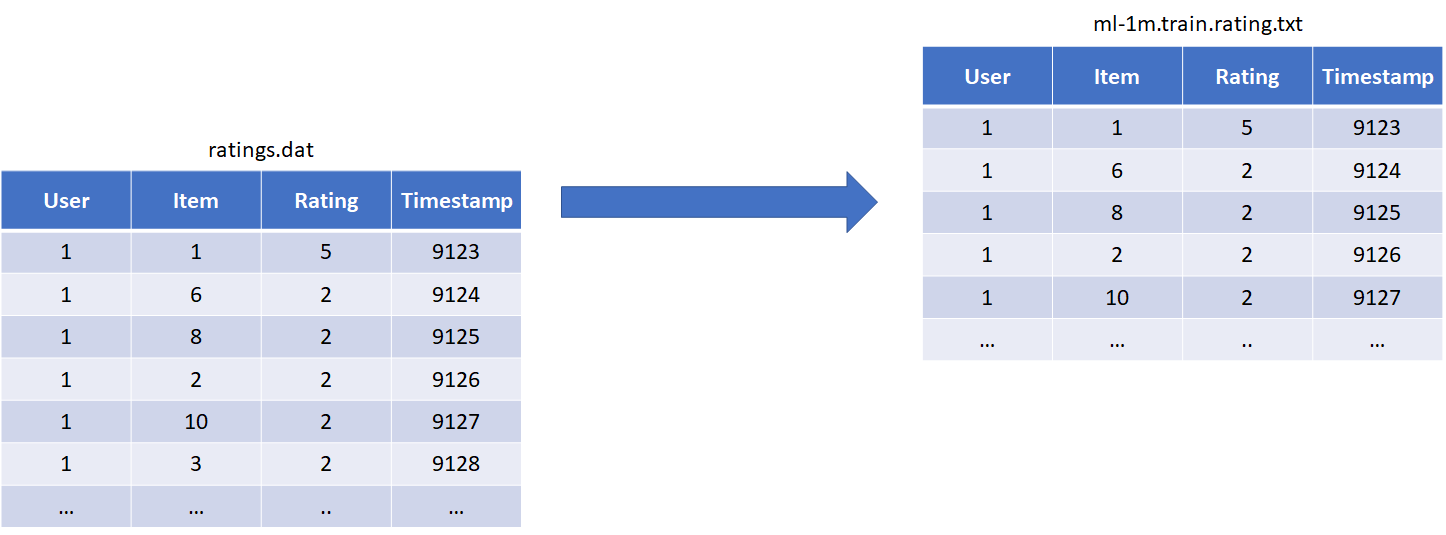

<br><br><br>

c. **Explain** how the test dataset is created.

Explain it above in word, but here is an image:
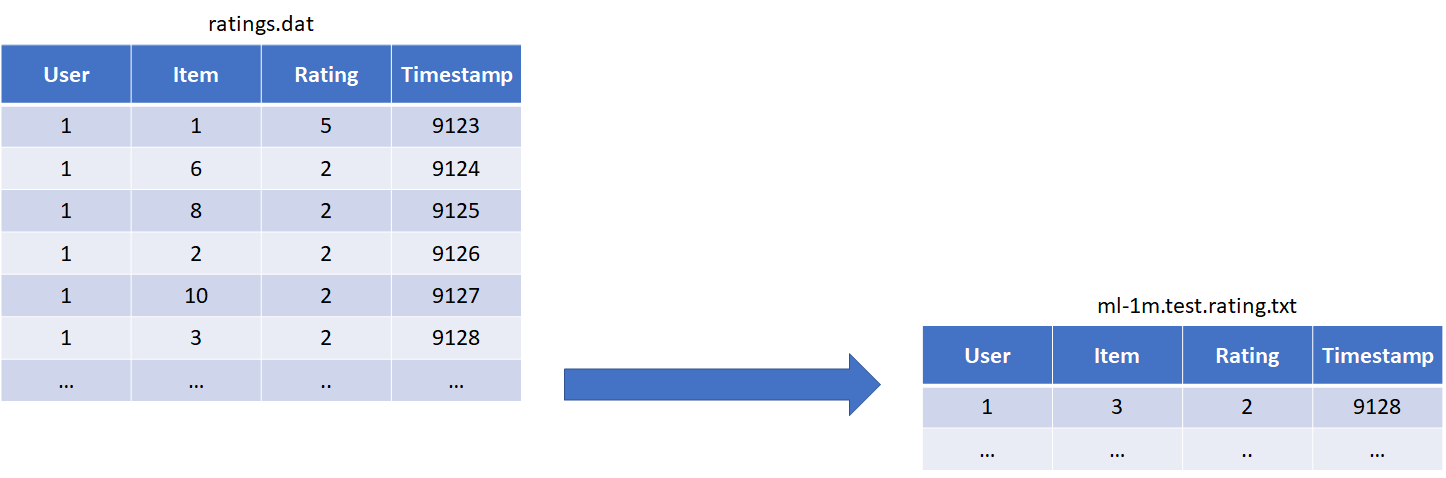

<br><br><br>

<br><br><br>
<br><br><br>
<br><br><br>

## Question 2: Neural Collaborative filtering (40 points)
<br><br>

#### Data Preperations:

using pandas:

In [209]:
data_dir = 'data/'

file_train    = 'data/ml-1m.train.rating.txt'
file_test     = 'data/ml-1m.test.rating.txt'
file_test_neg = 'data/ml-1m.test.negative.txt'

columns = ['userId','itemId','rating','timestamp']

df_train = pd.read_csv(file_train, sep="\t", header=None,names=columns)
df_test = pd.read_csv(file_test, sep="\t", header=None,names=columns)
df_test_neg = pd.read_csv(file_test_neg, sep="\t", header=None)

using a costum dataset class (from sample notebook):

In [177]:
class Dataset(object):
    '''
    classdocs
    '''

    def __init__(self, path):
        '''
        Constructor
        '''
        self.trainMatrix = self.load_rating_file_as_matrix(path + "ml-1m.train.rating.txt")
        self.testRatings = self.load_rating_file_as_list(path + "ml-1m.test.rating.txt")
        self.testNegatives = self.load_negative_file(path + "ml-1m.test.negative.txt")
        assert len(self.testRatings) == len(self.testNegatives)
        
        self.num_users, self.num_items = self.trainMatrix.shape
        
    def load_rating_file_as_list(self, filename):
        ratingList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])
                ratingList.append([user, item])
                line = f.readline()
        return ratingList
    
    def load_negative_file(self, filename):
        negativeList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                negatives = []
                for x in arr[1: ]:
                    negatives.append(int(x))
                negativeList.append(negatives)
                line = f.readline()
        return negativeList
    
    def load_rating_file_as_matrix(self, filename):
        '''
        Read .rating file and Return dok matrix.
        The first line of .rating file is: num_users\t num_items
        '''
        # Get number of users and items
        num_users, num_items = 0, 0
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                u, i = int(arr[0]), int(arr[1])
                num_users = max(num_users, u)
                num_items = max(num_items, i)
                line = f.readline()
        # Construct matrix
        mat = sp.sparse.dok_matrix((num_users+1, num_items+1), dtype=np.float32)
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
                if (rating > 0):
                    mat[user, item] = 1.0
                line = f.readline()    
        return mat
    
    
    def get_train_instances(self,num_negatives=4):
        user_input, item_input, labels = [],[],[]
        num_users, num_items = self.trainMatrix.get_shape()
        for (u, i) in self.trainMatrix.keys():
            # positive instance
            user_input.append(u)
            item_input.append(i)
            labels.append(1)
            # negative instances
            for t in range(num_negatives):
                j = np.random.randint(num_items)
                while (u, j) in self.trainMatrix:
                    j = np.random.randint(num_items)
                user_input.append(u)
                item_input.append(j)
                labels.append(0)
        return user_input, item_input, labels

In [178]:
dataset = Dataset(data_dir)
train, testRatings, testNegatives = dataset.trainMatrix, dataset.testRatings, dataset.testNegatives
num_users, num_items = train.get_shape()
'users',num_users, 'items',num_items, 'train',train.nnz, 'test',len(testRatings)

('users', 6040, 'items', 3706, 'train', 994169, 'test', 6040)

In [153]:
# Global variables that are shared across processes
_model = None
_testRatings = None
_testNegatives = None
_K = None

def evaluate_model(model, testRatings, testNegatives, K, num_thread):
    """
    Evaluate the performance (Hit_Ratio, NDCG) of top-K recommendation
    Return: score of each test rating.
    """
    global _model
    global _testRatings
    global _testNegatives
    global _K
    _model = model
    _testRatings = testRatings
    _testNegatives = testNegatives
    _K = K
        
    hits, ndcgs, mrrs = [],[],[]
    if(num_thread > 1): # Multi-thread
        pool = multiprocessing.Pool(processes=num_thread)
        res = pool.map(eval_one_rating, range(len(_testRatings)))
        pool.close()
        pool.join()
        hits = [r[0] for r in res]
        ndcgs = [r[1] for r in res]
        mrrs = [r[2] for r in res]
        return (hits, ndcgs, mrrs)
    
    # Single thread
    for idx in range(len(_testRatings)):
        (hr,ndcg,mrr) = eval_one_rating(idx)
        hits.append(hr)
        ndcgs.append(ndcg)  
        mrrs.append(mrr)    
    return (hits, ndcgs, mrrs)

def eval_one_rating(idx):
    rating = _testRatings[idx]
    items = _testNegatives[idx]
    u = rating[0]
    gtItem = rating[1]
    items.append(gtItem)
    # Get prediction scores
    map_item_score = {}
    users = np.full(len(items), u, dtype = 'int32')
    predictions = _model.predict([users, np.array(items)], 
                                 batch_size=100, verbose=0)
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i]
    items.pop()
    
    # Evaluate top rank list
    ranklist = heapq.nlargest(_K, map_item_score, key=map_item_score.get)
    hr = getHitRatio(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    mrr = getMRR(ranklist, gtItem)
    return (hr, ndcg, mrr)

In [155]:
def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0
  
def getMRR(ranklist, gtItem):
    num_movies_tested = 0
    for item in ranklist:
        num_movies_tested += 1
        if item == gtItem:
            mrr = 1 / num_movies_tested
            return mrr
    return 0

In [157]:
num_factors = 8 #size of embedding size. Can be split to 4 different params potentially.
num_negatives = 4 #how many negative samples per positive sample?
learning_rate = 0.001
epochs = 10
batch_size = 64
verbose = 1
write_model=False
# topK = 10 #used to evaluate the model. Top K recommendations are used.
top_5k = 5
top_10k = 10
evaluation_threads = 1 
K_LATENT = 20
hidden_dim = 20
do = 0.5
# model_out_file = 'Pretrain/%s_GMF_%d_%d.h5' %(dataset, num_factors, time())

In [179]:
user_input, item_input, labels = dataset.get_train_instances(num_negatives)

In [535]:
class Dataset_train(Dataset):
    
    def __init__(self, df_train,n_neg_samples):
        
        self.transform = ToTensor()

        
        # create new data
        samples = df_train[df_train.columns[:-1]].copy()
        samples.rating = 1
        
        users = samples.userId.unique()
        items = samples.itemId.unique()

        self.n_neg = n_neg_samples

        # create all neg for each user
        for u in users:
            user_items = samples[samples.userId==u].itemId.unique()
            neg_items = np.random.choice(items[~np.isin(items,user_items)],self.n_neg*len(user_items))

            l = [np.ones_like(neg_items)*u,neg_items,np.zeros_like(neg_items)]
            df_u = pd.DataFrame(np.array(l).T,columns=samples.columns)

            samples = samples.append(df_u)
        
        self.data = samples.values
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        u,i,l = self.data[index]
        return [u,i],l
    

dataset_train = Dataset_train(df_train,num_negatives)
trainloader = DataLoader(dataset_train, batch_size=64, shuffle=True)

# sanity check 
iter(trainloader).next()

[[tensor([1500, 2888, 3310, 5326, 4630,  835, 1723, 2097, 2401, 5635, 4897, 1919,
          4660, 3606, 3470, 5099, 5225, 1938, 3578, 1823,   16, 4166, 1732, 2610,
          3531, 1705, 3033, 5746, 4110, 3939,  446, 1766, 1171, 5069, 2401, 2886,
          5613, 2564, 5535, 2079, 4590,  106, 2124, 2452, 5481, 2933, 1597, 1469,
          1979,  315, 5370,  730, 5674, 2287, 3021, 1208, 4801, 4496, 2007, 3225,
          2128, 5642, 4974, 2771]),
  tensor([ 958, 2700, 1641, 3354,  124, 1593, 1442, 3679, 1474, 2071,  933, 1595,
          1560,  639, 2325, 2122, 1868, 1183,  856,  557, 1883, 1851, 2261, 2208,
           123,  895, 2545, 2211,   12, 2841, 2848, 3077, 3448,  687, 3365, 2568,
          3449, 3051, 2701,  795,  535, 3642, 3588, 1380,  307, 2760,  532, 1096,
          1611, 2875, 1982,   76, 1380,  928,  167, 2654,  533, 1698,  322, 2261,
          2429, 2931, 1871, 1277])],
 tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0,

a. Build the following four models using the neural collaborative filtering approach: 
- Matrix Factorization (MF)
- Multi layer perceptron (MLP)
- Generalized Matrix Factorization (GMF) 
- NeuroMatrixFactorization (NMF)

In [392]:
n_latent = 5
n_users = df_train.userId.unique().shape[0]
n_items = df_train.itemId.unique().shape[0]

In [538]:
class MF(nn.Module):
    def __init__(self,n_users,n_items,n_latent):
        super(MF, self).__init__()
        
        self.emb_users = Embedding(n_users,n_latent)
        self.emb_items = Embedding(n_items,n_latent)
        
        self.l = Linear(n_latent,1)
        self.ac = Sigmoid()
        
    def forward(self, x_users,x_items):
        
        x_users = self.emb_users(x_users)
        x_items = self.emb_items(x_items)
        
        x = torch.matmul(x_users,x_items)
        x = self.l(x)
        x = self.ac(x)
        
        return x

        
# sanity check ??????????????????????????????????????
model = MF(n_users,n_items,n_latent)
inputs,labels = iter(trainloader).next()
model(*inputs),labels

RuntimeError: size mismatch, m1: [64 x 5], m2: [64 x 5] at C:\w\1\s\tmp_conda_3.7_100118\conda\conda-bld\pytorch_1579082551706\work\aten\src\TH/generic/THTensorMath.cpp:136

In [442]:
class MLP(nn.Module):
    def __init__(self,n_users,n_items,n_latent=5,sizes=[20,10]):
        super(MLP, self).__init__()
        
        self.emb_users = Embedding(n_users,n_latent)
        self.emb_items = Embedding(n_items,n_latent)
        
        # n linear layers
        layers = [Linear(2*n_latent,sizes[0])]
        for in_f, out_f in zip(sizes, sizes[1:]):
            layers.append(Linear(in_f,out_f))
            layers.append(ReLU())
        
        layers.append(Linear(sizes[-1],1))
        layers.append(Sigmoid())
        
        self.linears = Sequential(*layers)
        
    
    def forward(self, x_users,x_items):
        
        x_users = self.emb_users(x_users)
        x_items = self.emb_items(x_items)
        
        x = torch.cat([x_users,x_items],dim=1) # keep batch size
        x = self.linears(x)
        return x
        
        
# sanity check 
model = MLP(n_users,n_items,n_latent)
inputs,labels = iter(trainloader).next()
model(*inputs),labels

(tensor([[0.4094],
         [0.4278],
         [0.4354],
         [0.4020],
         [0.3598]], grad_fn=<SigmoidBackward>),
 tensor([0, 0, 0, 0, 0]))

In [443]:
class GFM(nn.Module):
    def __init__(self,n_users,n_items,n_latent=5,p_drop=1):
        super(GFM, self).__init__()
        
        self.emb_users = Embedding(n_users,n_latent)
        self.emb_items = Embedding(n_items,n_latent)
        
        self.d = Dropout(p_drop)
        
        self.l = Linear(n_latent,1)
        self.ac = Sigmoid()
        
    def forward(self, x_users,x_items):
        
        x_users = self.emb_users(x_users)
        x_items = self.emb_items(x_items)
        
        x = torch.matmul(x_users,x_items)
        x = self.d(x)
        x = self.l(x)
        x = self.ac(x)
        
        return x

    
# sanity check 
model = GFM(n_users,n_items,n_latent)
inputs,labels = iter(trainloader).next()
model(*inputs),labels

(tensor([[0.4772],
         [0.4772],
         [0.4772],
         [0.4772],
         [0.4772]], grad_fn=<SigmoidBackward>),
 tensor([1, 0, 0, 0, 0]))

In [444]:
class NMF(nn.Module):
    def __init__(self,n_users,n_items,n_latent_MF=5, n_latent_MLP=10,sizes=[20,10]):
        super(NMF, self).__init__()
        
        # MF
        self.MF_emb_users = Embedding(n_users,n_latent_MF)
        self.MF_emb_items = Embedding(n_items,n_latent_MF)
        
        # MLP
        self.MLP_emb_users = Embedding(n_users,n_latent_MLP)
        self.MLP_emb_items = Embedding(n_items,n_latent_MLP)
        layers = [Linear(2*n_latent_MLP,sizes[0])]
        for in_f, out_f in zip(sizes, sizes[1:]):
            layers.append(Linear(in_f,out_f))
            layers.append(ReLU())
        self.linears = Sequential(*layers)
        
        # combine
        self.final  = Sequential(Linear(n_latent_MF + sizes[-1],1),Sigmoid())
        
    
    def forward(self, x_users,x_items):
        
        # MF
        x_users_MF = self.MF_emb_users(x_users)
        x_items_MF = self.MF_emb_items(x_items)
        x_MF= torch.matmul(x_users_MF,x_items_MF)

        # MLP
        x_users_MLP = self.MLP_emb_users(x_users)
        x_items_MLP = self.MLP_emb_items(x_items)
        x_MLP = torch.cat([x_users_MLP,x_items_MLP],dim=1)
        x_MLP = self.linears(x_MLP)

        # combine 
        x = torch.cat([x_MF,x_MLP],dim=1)
        x = self.final(x)
        return x

# sanity check 
model = NMF(n_users,n_items,n_latent,2*n_latent)
inputs,labels = iter(trainloader).next()
model(*inputs),labels

(tensor([[0.4943],
         [0.5850],
         [0.2793],
         [0.4793],
         [0.8149]], grad_fn=<SigmoidBackward>),
 tensor([0, 0, 0, 0, 0]))

b. Train and evaluate the recommendations accuracy of three models: 
- MF or GMF
- MLP
- NMF

Compare the learning curve and recommendations accuracy using NDCG and MRR metrics with cutoff values of 5 and 10.   
Discuss the comparison. 

In [537]:
def train_model(DEVICE,model,trainloader,testloader=None,verbose=False,n_epochs=3,lr=1e-3,reg=1e-5):

    model = model.to(DEVICE)
    total_len = len(trainloader)
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=reg)

    loss_values = []
    loss_values_test = []
    for epoch in range(n_epochs):  

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
          
            inputs, labels = data
            inputs = [i.to(DEVICE) for i in inputs]
            labels = labels.to(DEVICE).float()

            optimizer.zero_grad()

            outputs = model(*inputs)
            outputs = outputs
            
            loss = criterion(outputs, labels)
          
            loss.backward()
          
            optimizer.step()

            running_loss += loss.item()
            
        # save loss of epoch
        loss_values.append(running_loss / len(trainloader))

        if testloader is not None:
            with torch.no_grad():
                running_loss = 0.0
                for i, data in enumerate(testloader, 0):
            
                    inputs, labels = data
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)
                    outputs = model(*inputs)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()
                loss_values_test.append(running_loss / len(testloader))

        if verbose:
            print('epoch [{}/{}], train_loss:{:.4f}, valid_loss:{:.4f}'.format(epoch + 1, n_epochs,loss_values[-1],loss_values_test[-1]  ))

    if testloader is not None:
        return loss_values,loss_values_test

    return loss_values


# sanity check 
model = MF(n_users,n_items,n_latent)
train_model('cpu',model,trainloader)

RuntimeError: size mismatch, m1: [64 x 5], m2: [64 x 5] at C:\w\1\s\tmp_conda_3.7_100118\conda\conda-bld\pytorch_1579082551706\work\aten\src\TH/generic/THTensorMath.cpp:136

c. How the values of MRR and NDCG are differ from the results you got in the previous exercises which implemented the explicit recommendation approach. 
What are the difference in preparing the dataset for evaluation. 

d. How will you measure item similarity using the NeuMF model?

<br><br><br>
<br><br><br>
<br><br><br>

## Question 3: Loss function (25 points)
<br><br>

a. One of the enhancements presented in the Neural Collaborative Filtering paper is the usage of probabilistic activation function (the sigmoid) and binary cross entropy loss function.   

Select one of the models you implemented in question 2 and change the loss function to a Mean Squared Error and the activation function of the last layer to RELU.   

Train the model and evaluate it in a similar way to what you did in question 2. 
Compare the results and discuss.

<br><br><br>
<br><br><br>
<br><br><br>

## Question 4: Hybrid recommender systems (25 points)
<br><br>

a. Take a look at the original MovieLens 1M dataset. Which user and movie features could you use to enhance your recommender system and provide effective recommendations to users or items with a small number of ratings.

b. Describe a neural network based model to incorporate user or movie related features to the recommender system. (no need to implement). 

c. How will you incorporate movie genres into the recommender system?   
How will you handle movies which belong to multiple genres? (no need to implement). 

<br><br><br>
<br><br><br>

Good luck